In [1]:
import torch as T
import numpy as np
from matplotlib import pyplot as pt

import models
import util

device = T.device('cuda')

T.set_grad_enabled(False)

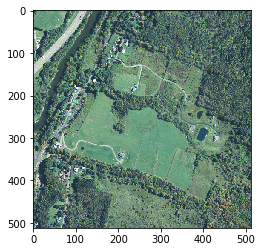

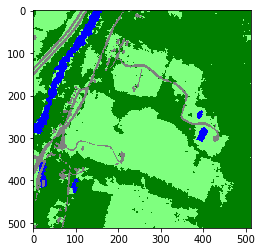

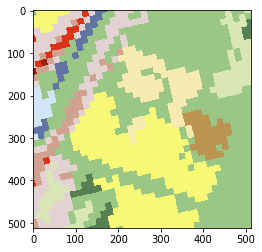

In [2]:
# load data and visualize it

img, lc, nlcd = util.load_data()

pt.imshow(img[:3].T); pt.show()
pt.imshow(util.vis_lc(lc, True).T); pt.show()
pt.imshow(util.vis_nlcd(nlcd, True).T); pt.show()

In [3]:
# compute low-res embedding
def lr_embed(image, lowres, patch_size, max_iter=201, batch_size=64):
    # set up epitome model with uniform variance
    ep = models.EpitomeModel(image.shape[-1],4,1).to(device)
    ep.prior[:] = 0.
    ep.mean[0] = T.from_numpy(image)
    ep.ivar[:] = 100.

    # initialize counters
    lrmap = T.zeros((len(util.nlcd_cl),ep.layers,ep.size,ep.size)).to(device)
    
    for it in range(max_iter):
        #construct batches
        batch = np.zeros((batch_size,4,patch_size,patch_size))
        lc_batch = np.zeros((batch_size,patch_size,patch_size))
        nlcd_ctr = np.zeros((batch_size,), dtype=np.int)

        for b in range(batch_size):
            x = np.random.randint(image.shape[1]-patch_size+1)
            y = np.random.randint(image.shape[2]-patch_size+1)
            batch[b] = image[:,x:x+patch_size,y:y+patch_size]
            nlcd_ctr[b] = util.c2i[int(lowres[x+patch_size//2,y+patch_size//2])]
        x = T.from_numpy(batch).to(device,T.float)

        # compute smoothed posterior and embed
        posterior = (ep(x).view(batch_size,-1) / patch_size**2).softmax(1).view(batch_size,ep.layers,ep.size,ep.size)
        for j in range(batch_size):
            lrmap[nlcd_ctr[j]] += posterior[j]

    return lrmap.cpu().numpy()

# super-resolution EM algorithm
def superres(nlcdmap, max_iter=20):
    eps=0.00000000001
    
    # use the full p(l,c)
    nlcd_mu = util.nlcd_mu #nlcdmap.sum((1,2,3)).reshape(22,1)**0.1
    p_l_c = T.from_numpy(nlcd_mu).float().to(device)

    # init the p(s|c): renormalize priors, then normalize over positions
    p_s_c = (T.from_numpy(lrmap).float() + eps).to(device)
    p_s_c /= (p_s_c.sum(0))
    p_s_c /= p_s_c.sum((1,2,3)).view(-1,1,1,1)
    
    # init the p(l|s) and q(s|l,c)
    p_l_s = (T.rand(p_s_c.shape[1:]+(4,))+10).to(device)
    p_l_s /= p_l_s.sum(3).unsqueeze(3)
    q = T.empty(p_s_c.shape[1:] + p_l_c.shape)

    for it in range(max_iter):
        # E step
        q = T.einsum('exyl,cexy->exycl',p_l_s,p_s_c) + eps
        q /= q.sum((0,1,2))

        # M step
        p_l_s = T.einsum('exycl,cl->exyl',q,p_l_c)+eps
        p_l_s /= p_l_s.sum(3).unsqueeze(3)

    return p_l_s.cpu().numpy()


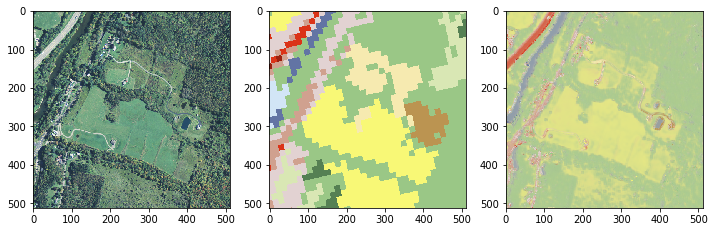

In [6]:
# compute low-res map and visualize it

patch_size = 7
samples = 20000
batch_size = 64

lrmap = lr_embed(img, nlcd, patch_size, samples // 64, 64)

pt.figure(figsize=(12,4))
pt.subplot(131); pt.imshow(img[:3].T)
pt.subplot(132); pt.imshow(util.vis_nlcd(nlcd,True).T) # original labels
pt.subplot(133); pt.imshow(util.vis_nlcd(lrmap[:,0]).T) # reembedded labels
pt.show()

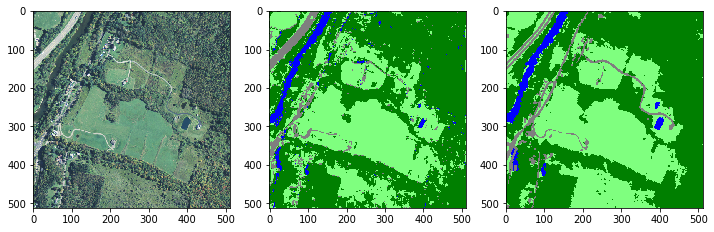

In [7]:
# run SR algorithm and visualize it

hrp = superres(lrmap)

pt.figure(figsize=(12,4))
pt.subplot(131); pt.imshow(img[:3].T)
pt.subplot(132); pt.imshow(util.vis_lc(hrp[0].argmax(-1).T,True).T.swapaxes(0,1)) # SR output
pt.subplot(133); pt.imshow(util.vis_lc(lc, True).T) # ground truth

pt.show()